<a href="https://colab.research.google.com/github/gabrielebilliciani/knowledge-distillation/blob/main/Notebook2_KD_Classification_MLPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation for Handwritten Digit Classification

### An Empirical Study of Teacher-Student Learning on MNIST

> **Note**: This notebook is part of an introductory project on Knowledge Distillation. It serves as a practical companion to the main presentation slides. The complete project is available on GitHub at: https://github.com/gabrielebilliciani/knowledge-distillation

This notebook provides a detailed, hands-on exploration of **Knowledge Distillation (KD)**, a powerful model compression technique popularized by Geoffrey Hinton et al. We apply this method to the classic MNIST dataset of handwritten digits to demonstrate its effectiveness in a **classification setting**.

The core principle of KD is to transfer "knowledge" from a large, high-performing **teacher** model to a smaller, more efficient **student** model. The student learns to mimic the rich, soft probability distributions of the teacher, not just the final hard predictions. The goal is to enable the student to achieve performance that surpasses what it could learn on its own, creating a model that is both accurate and computationally efficient for deployment.

#### Experimental Structure
This notebook is structured as a rigorous experiment to validate the effectiveness of distillation:
1.  **Teacher & Student Architectures:** We define a deep, high-capacity "teacher" network and a much shallower "student" network.
2.  **Robust Training:** We implement a robust training pipeline with a train/validation split, early stopping, and learning rate scheduling to ensure fair and reliable model evaluation.
3.  **Statistical Significance:** We train the student models over multiple runs (`N=5`) with different random seeds to ensure our results are statistically significant.
4.  **Temperature Scaling Analysis:** We conduct a sweep of the distillation **temperature (`T`)** hyperparameter to find its optimal value and visualize its impact on student performance.
5.  **Hypothesis Testing:** We use a **Wilcoxon signed-rank test** to formally determine if the performance gains from distillation are statistically significant, given that the results on a simple task such as classification on MNIST Dataset are very close to each other.

#### The Distillation Loss Function
The student model is trained by optimizing a composite loss function, $L_{KD}$, which is a weighted average of two distinct objectives:

$$
L_{KD}(x, y) = \alpha \cdot L_{\text{soft}}(x, T) + (1 - \alpha) \cdot L_{\text{hard}}(x)
$$

Where:
-   $L_{\text{hard}}$ is the standard **Cross-Entropy Loss** between the student's predictions and the ground-truth labels ($y$). This ensures the student learns the primary task.
-   $L_{\text{soft}}$ is the **KL Divergence Loss** between the softened predictions of the student and the teacher, both computed at a temperature $T > 1$. This is the core distillation signal that transfers the "dark knowledge".
-   $\alpha$ is a hyperparameter that balances the contribution of the two loss terms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from scipy import stats
from tqdm.notebook import tqdm # Import tqdm for progress bars

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a directory for saving models
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

Using device: cuda


## 2. Hyperparameters and Experimental Configuration
This cell centralizes all key parameters for our experiments. Defining them here allows for easy modification and ensures reproducibility.

#### Training and Model Parameters
- **`BATCH_SIZE`**, **`MAX_EPOCHS`**: Define the batch size for training and the maximum number of epochs. Our early stopping mechanism may terminate training before this limit.
- **`LR_...`**: The learning rates for the Adam optimizer. We set these individually for the teacher and student models.
- **`INPUT_SIZE`**, **`NUM_CLASSES`**: Define the input dimensions (28x28 pixels for MNIST) and the number of output classes (10 digits).

#### Distillation Parameters
- **`ALPHA`**: This hyperparameter balances the soft-target loss (from the teacher) and the hard-target loss (from the data). A higher alpha prioritizes mimicking the teacher.
- **`TEMPERATURES`**: A list of temperature values we will sweep through to analyze their effect on distillation performance.

#### Optimization and Regularization
- **`PATIENCE_...`**, **`MIN_DELTA_...`**: These control our early stopping and learning rate scheduler callbacks, which improve training stability and prevent overfitting by monitoring validation loss.

In [ ]:
BATCH_SIZE = 2048
MAX_EPOCHS = 50 # Increased max epochs, early stopping will handle if fewer are needed

LR_TEACHER = 0.001
LR_STUDENT_SCRATCH = 0.001
LR_STUDENT_DISTILLED = 0.003

# Distillation parameters (Temperature is missing because we will perform Temperature Scailing)
ALPHA = 0.7

INPUT_SIZE = 28 * 28
NUM_CLASSES = 10

# Early Stopping & LR Scheduler Parameters
PATIENCE_EARLY_STOPPING = 7 # Number of epochs to wait for improvement before stopping
MIN_DELTA_EARLY_STOPPING = 0.0001 # Minimum change in val_loss to be considered an improvement
PATIENCE_LR_SCHEDULER = 3 # Number of epochs to wait for val_loss improvement before reducing LR
FACTOR_LR_SCHEDULER = 0.1 # Factor by which LR is reduced

VAL_SPLIT_RATIO = 0.2 # 20% of training data for validation

## 3. Data Acquisition and Preprocessing
This cell handles the loading and preparation of the MNIST dataset.

1.  **Transforms**: We define a sequence of transformations. `transforms.ToTensor()` converts images to PyTorch tensors, and `transforms.Normalize()` standardizes the data using the known mean and standard deviation of the MNIST dataset, which helps stabilize training.
2.  **Dataset Loading**: We download the official MNIST training and test sets.
3.  **Train/Validation Split**: We split the full training set into a new, smaller training set and a validation set. This is critical for unbiased monitoring of model performance during training for early stopping and LR scheduling.
4.  **DataLoaders**: We wrap our datasets in `DataLoader` instances to efficiently iterate over the data in shuffled mini-batches.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full training dataset
train_full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Split training data into training and validation
num_train_samples = len(train_full_dataset)
val_size = int(VAL_SPLIT_RATIO * num_train_samples)
train_size = num_train_samples - val_size

train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

Training samples: 48000
Validation samples: 12000
Test samples: 10000


## 4. Model Architectures

### Teacher Model (Deep MLP)
Here we define the architecture for our somehow "big" teacher model. It is a deep Multi-Layer Perceptron (MLP) , thar can learn robust and accurate features from the data. It uses `LeakyReLU` activations to prevent the "dying ReLU" problem and incorporates `BatchNorm1d` and `Dropout` for regularization and training stability.

In [ ]:
class TeacherNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TeacherNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc6 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return x

### Student Model (2-Layer MLP)
This is our smaller, more efficient "student" model. Its architecture is a very shallow MLP with only one hidden layer. This simplicity makes it fast and lightweight but limits its standalone performance, making it a perfect candidate to see if distillation can effectively improve the model's capabilities.

In [ ]:
class StudentNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(StudentNet, self).__init__()
        # Layer 1: Input to Hidden
        self.fc1 = nn.Linear(input_size, 64) # Hidden layer with 64 units
        self.bn1 = nn.BatchNorm1d(64)
        # Layer 2: Hidden to Output
        self.fc_out = nn.Linear(64, num_classes) # Output layer

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.bn1(self.fc1(x))) # Pass through the first (hidden) layer
        x = self.fc_out(x) # Pass through the second (output) layer
        return x

## 5. Core Training and Evaluation Functions
This cell contains the core logic for training and evaluation.

- **`train_epoch_fn`**: Executes a standard training epoch using the ground-truth labels (`hard loss`).
- **`distill_epoch_fn`**: Implements the knowledge distillation training for an epoch. It calculates the weighted sum of the `hard loss` and the `soft loss` (from the teacher's softened logits).
- **`evaluate_fn`**: A utility to evaluate model performance on a dataset without performing gradient updates.

In [ ]:
def train_epoch_fn(model, device, train_loader, optimizer, epoch_num, model_type="Model"):
    model.train()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Wrap train_loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num} | {model_type}", leave=False)

    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = 100. * correct_predictions / total_samples
    return epoch_loss, epoch_acc

def distill_epoch_fn(student_model, teacher_model, device, train_loader, optimizer, epoch_num, temperature, alpha):
    student_model.train()
    teacher_model.eval()

    criterion_hard = nn.CrossEntropyLoss()
    criterion_soft = nn.KLDivLoss(reduction='batchmean')

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num} | Student (T={temperature})", leave=False)

    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = teacher_model(data)
        student_logits = student_model(data)

        loss_hard = criterion_hard(student_logits, target)

        soft_teacher_outputs = F.softmax(teacher_logits / temperature, dim=1)
        soft_student_outputs = F.log_softmax(student_logits / temperature, dim=1)
        # Scale soft loss by T^2, as recommended in Hinton's paper
        loss_soft = criterion_soft(soft_student_outputs, soft_teacher_outputs) * (temperature ** 2)

        loss = alpha * loss_soft + (1 - alpha) * loss_hard

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(student_logits.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        # Update the progress bar with soft and hard loss components
        progress_bar.set_postfix(total_loss=f"{loss.item():.4f}", soft_loss=f"{loss_soft.item():.4f}", hard_loss=f"{loss_hard.item():.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = 100. * correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_fn(model, device, data_loader, model_type="Model", eval_mode="Validation"):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    eval_loss = 0.0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            eval_loss += criterion(outputs, target).item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct += (predicted == target).sum().item()

    eval_loss /= total_samples
    accuracy = 100. * correct / total_samples

    # Only print the summary for the final test evaluation, not for every validation epoch
    if eval_mode == "Test":
        print(f'\\n{model_type} - {eval_mode} set: Average loss: {eval_loss:.4f}, Accuracy: {correct}/{total_samples} ({accuracy:.2f}%)\\n')

    return eval_loss, accuracy

## 6. Generic Training Function
This function abstracts the boilerplate of looping through epochs. It handles both standard and distillation training, saves the best model, and implements early stopping and LR scheduling.

In [ ]:
def run_training_loop(model, optimizer, scheduler, train_fn,
                      train_loader, val_loader, device, max_epochs,
                      model_save_path, model_type_name,
                      teacher_model=None, temperature=None, alpha=None):

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_accuracy = 0.0
    best_val_loss_for_scheduler_es = float('inf')
    epochs_no_improve = 0

    print(f"--- Training {model_type_name} ---")
    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        if teacher_model: # Distillation training
            train_loss, train_acc = train_fn(model, teacher_model, device, train_loader, optimizer, epoch, temperature, alpha)
        else: # Standard training
            train_loss, train_acc = train_fn(model, device, train_loader, optimizer, epoch, model_type_name)

        val_loss, val_acc = evaluate_fn(model, device, val_loader, model_type_name, "Validation")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Save best model based on validation accuracy (suppress printout)
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), model_save_path)
            # print(f"Epoch {epoch}: New best {model_type_name} saved with validation accuracy: {val_acc:.2f}%")

        # LR Scheduler and Early Stopping (based on validation loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss_for_scheduler_es - MIN_DELTA_EARLY_STOPPING:
            best_val_loss_for_scheduler_es = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            # print(f"Epoch {epoch}: No improvement in val_loss for {epochs_no_improve} epochs.") # Suppressed

        if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
            print(f"Early stopping triggered at epoch {epoch} for {model_type_name}!")
            break

    training_time = time.time() - start_time
    print(f"{model_type_name} training finished in {training_time:.2f}s after {epoch} epochs.")

    # Load the best model for final evaluation
    print(f"Loading best {model_type_name} from: {model_save_path}")
    model.load_state_dict(torch.load(model_save_path))
    model.to(device) # Ensure model is on the correct device after loading

    return model, train_losses, train_accs, val_losses, val_accs, training_time, best_val_accuracy

## 7. Experimental Procedure and Analysis

This is the main driver cell of the notebook. It executes our full experimental plan.

1.  **Part 1: Train the Teacher Model**: We train the teacher network only once, since there is no need to do it multiple times. This model will act as a consistent knowledge source for all the subsequent student experiments.

2.  **Part 2: Statistical Loop & Temperature Sweep**: We loop `NUM_RUNS` times. In each run:
    * A new random seed is used to ensure varied initial conditions.
    * A single set of initial student weights is generated.
    * A baseline "Student (Scratch)" model is trained using these weights.
    * A nested loop then iterates through our list of `TEMPERATURES`. For each temperature, a new "Student (Distilled)" model is trained, always starting from the **same initial weights** as the scratch model for a fair, paired comparison. We do not want any random effect to influence our results, especially under these conditions, with very similar accuracies between the two students.

3.  **Part 3: Results Aggregation and Evaluation**: After all runs, we compute the mean and standard deviation of the test accuracies for each condition. We generate a plot of **Accuracy vs. Temperature** and perform a **Wilcoxon signed-rank test** to determine if the improvements from distillation are statistically significant.

In [ ]:
# --- Configuration for Multiple Runs and Temperature Sweep ---
NUM_RUNS = 5
TEMPERATURES = [1.0, 2.5, 4.0, 7.0, 10.0]
BASE_SEED = 42

# --- 1. Train the Teacher Model ONCE ---
print("="*60)
print("              TRAINING THE TEACHER MODEL (ONCE)")
print("="*60)
torch.manual_seed(BASE_SEED)

teacher_model = TeacherNet(INPUT_SIZE, NUM_CLASSES).to(device)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=LR_TEACHER)
scheduler_teacher = optim.lr_scheduler.ReduceLROnPlateau(optimizer_teacher, 'min',
                                                         patience=PATIENCE_LR_SCHEDULER,
                                                         factor=FACTOR_LR_SCHEDULER)
teacher_model_save_path = 'saved_models/best_teacher_model.pth'

# Capture the teacher's history
best_teacher_model, T_train_loss, T_train_acc, T_val_loss, T_val_acc, _, _ = \
    run_training_loop(teacher_model, optimizer_teacher, scheduler_teacher, train_epoch_fn,
                      train_loader, val_loader, device, MAX_EPOCHS,
                      teacher_model_save_path, "Teacher")

teacher_history = {
    'train_loss': T_train_loss, 'train_acc': T_train_acc,
    'val_loss': T_val_loss, 'val_acc': T_val_acc
}

print("\n--- Evaluating Teacher Model on Test Set ---")
_, teacher_test_acc = evaluate_fn(best_teacher_model, device, test_loader, "Teacher", "Test")

# --- Initialize data structures for storing results & histories ---
all_scratch_accuracies = []
distilled_accuracies_by_T = {T: [] for T in TEMPERATURES}

# To store the histories of the best models
best_scratch_run_history = {}
best_scratch_run_acc = 0.0
best_distilled_run_history = {}
best_distilled_run_acc = 0.0
best_distilled_run_info = {} # To store temp and name

# --- 2. Run Student Experiments Multiple Times ---
for i in range(NUM_RUNS):
    run_seed = BASE_SEED + i
    torch.manual_seed(run_seed)
    print(f"\n--- Starting Student Run {i+1}/{NUM_RUNS} (Seed: {run_seed}) ---")
    print("=" * 50)

    initial_student_net = StudentNet(INPUT_SIZE, NUM_CLASSES).to(device)
    initial_student_weights = copy.deepcopy(initial_student_net.state_dict())

    # Train Student from Scratch
    student_scratch_model = StudentNet(INPUT_SIZE, NUM_CLASSES).to(device)
    student_scratch_model.load_state_dict(initial_student_weights)
    optimizer_student_scratch = optim.Adam(student_scratch_model.parameters(), lr=LR_STUDENT_SCRATCH)
    scheduler_student_scratch = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student_scratch, 'min', patience=PATIENCE_LR_SCHEDULER, factor=FACTOR_LR_SCHEDULER)
    student_scratch_model_save_path = f'saved_models/best_student_scratch_model_run_{i}.pth'

    model_scratch, tr_loss, tr_acc, v_loss, v_acc, _, _ = \
        run_training_loop(student_scratch_model, optimizer_student_scratch, scheduler_student_scratch, train_epoch_fn,
                          train_loader, val_loader, device, MAX_EPOCHS,
                          student_scratch_model_save_path, f"Student (Scratch) (Run {i+1})")

    _, student_scratch_test_acc = evaluate_fn(model_scratch, device, test_loader, f"Student (Scratch) (Run {i+1})", "Test")
    all_scratch_accuracies.append(student_scratch_test_acc)

    if student_scratch_test_acc > best_scratch_run_acc:
        best_scratch_run_acc = student_scratch_test_acc
        best_scratch_run_history = {
            'train_loss': tr_loss, 'train_acc': tr_acc,
            'val_loss': v_loss, 'val_acc': v_acc
        }

    # Loop through temperatures for distilled models
    best_teacher_model.eval()
    for temp in TEMPERATURES:
        student_distilled_model = StudentNet(INPUT_SIZE, NUM_CLASSES).to(device)
        student_distilled_model.load_state_dict(initial_student_weights)

        optimizer_student_distilled = optim.Adam(student_distilled_model.parameters(), lr=LR_STUDENT_DISTILLED)
        scheduler_student_distilled = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student_distilled, 'min', patience=PATIENCE_LR_SCHEDULER, factor=FACTOR_LR_SCHEDULER)
        student_distilled_model_save_path = f'saved_models/best_student_distilled_model_T_{temp}_run_{i}.pth'

        model_distilled, tr_loss, tr_acc, v_loss, v_acc, _, _ = \
            run_training_loop(student_distilled_model, optimizer_student_distilled, scheduler_student_distilled, distill_epoch_fn,
                              train_loader, val_loader, device, MAX_EPOCHS,
                              student_distilled_model_save_path, f"Student (T={temp}) (Run {i+1})",
                              teacher_model=best_teacher_model, temperature=temp, alpha=ALPHA)

        _, student_distilled_test_acc = evaluate_fn(model_distilled, device, test_loader, f"Student (T={temp}) (Run {i+1})", "Test")
        distilled_accuracies_by_T[temp].append(student_distilled_test_acc)

        if student_distilled_test_acc > best_distilled_run_acc:
            best_distilled_run_acc = student_distilled_test_acc
            best_distilled_run_info = {'T': temp, 'acc': student_distilled_test_acc}
            best_distilled_run_history = {
                'train_loss': tr_loss, 'train_acc': tr_acc,
                'val_loss': v_loss, 'val_acc': v_acc
            }

    print(f"--- Finished Run {i+1}/{NUM_RUNS} ---\\n")

# --- 3. Final Analysis ---
print("\n" + "="*60)
print("       FINAL RESULTS: TEMPERATURE SCALING ANALYSIS")
print("="*60)

scratch_mean = np.mean(all_scratch_accuracies)
scratch_std = np.std(all_scratch_accuracies)
mean_accuracies_by_T = {T: np.mean(accs) for T, accs in distilled_accuracies_by_T.items()}
std_accuracies_by_T = {T: np.std(accs) for T, accs in distilled_accuracies_by_T.items()}

print("\n--- Test Set Accuracies (Mean ± Std. Dev. over 5 runs) ---")
print(f"Teacher Model (for reference)         : {teacher_test_acc:.2f}%")
print(f"Student Model (trained from scratch): {scratch_mean:.2f}% ± {scratch_std:.2f}")
for T in TEMPERATURES:
    print(f"Student Model (Distilled, T={T:<4}): {mean_accuracies_by_T[T]:.2f}% ± {std_accuracies_by_T[T]:.2f}")

# --- NEW: Statistical Significance Section with both tests ---
print("\n" + "-"*80)
print("            STATISTICAL SIGNIFICANCE vs. SCRATCH MODEL (alpha=0.05)")
print("-"*80)
print("Temp | Wilcoxon P-val | Wilcoxon Sig. | Paired t-test P-val | t-test Sig.")
print("-----|----------------|---------------|---------------------|-------------")

for T in TEMPERATURES:
    distilled_scores = distilled_accuracies_by_T[T]
    scratch_scores = all_scratch_accuracies

    # Wilcoxon signed-rank test (non-parametric)
    # Used for paired samples when the distribution of differences may not be normal.
    try:
        wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(
            x=distilled_scores,
            y=scratch_scores,
            alternative='greater' # One-sided test: is x's distribution greater than y's?
        )
        wilcoxon_sig = "✅ Yes" if wilcoxon_p_value < 0.05 else "❌ No"
    except ValueError:
        # Wilcoxon test fails if all differences are zero.
        wilcoxon_p_value = 1.0
        wilcoxon_sig = "N/A"


    # Paired t-test (parametric)
    # Used for paired samples, assumes differences are normally distributed.
    t_stat, t_p_value = stats.ttest_rel(
        a=distilled_scores,
        b=scratch_scores,
        alternative='greater' # One-sided test: is mean of a greater than mean of b?
    )
    ttest_sig = "✅ Yes" if t_p_value < 0.05 else "❌ No"

    print(f"{T:<4} | {wilcoxon_p_value:<14.4f} | {wilcoxon_sig:<13} | {t_p_value:<19.4f} | {ttest_sig:<11}")
print("-"*80)

              TRAINING THE TEACHER MODEL (ONCE)
--- Training Teacher ---


Epoch 1 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Teacher:   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 28 for Teacher!
Teacher training finished in 27.60s after 28 epochs.
Loading best Teacher from: saved_models/best_teacher_model.pth

--- Evaluating Teacher Model on Test Set ---
\nTeacher - Test set: Average loss: 0.0523, Accuracy: 9857/10000 (98.57%)\n

--- Starting Student Run 1/5 (Seed: 42) ---
--- Training Student (Scratch) (Run 1) ---


Epoch 1 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (Scratch) (Run 1):   0%|          | 0/24 [00:00<?, ?it/s]

Student (Scratch) (Run 1) training finished in 48.53s after 50 epochs.
Loading best Student (Scratch) (Run 1) from: saved_models/best_student_scratch_model_run_0.pth
\nStudent (Scratch) (Run 1) - Test set: Average loss: 0.1179, Accuracy: 9671/10000 (96.71%)\n
--- Training Student (T=1.0) (Run 1) ---


Epoch 1 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 39 for Student (T=1.0) (Run 1)!
Student (T=1.0) (Run 1) training finished in 38.09s after 39 epochs.
Loading best Student (T=1.0) (Run 1) from: saved_models/best_student_distilled_model_T_1.0_run_0.pth
\nStudent (T=1.0) (Run 1) - Test set: Average loss: 0.1024, Accuracy: 9710/10000 (97.10%)\n
--- Training Student (T=2.5) (Run 1) ---


Epoch 1 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=2.5) (Run 1) training finished in 48.20s after 50 epochs.
Loading best Student (T=2.5) (Run 1) from: saved_models/best_student_distilled_model_T_2.5_run_0.pth
\nStudent (T=2.5) (Run 1) - Test set: Average loss: 0.0875, Accuracy: 9733/10000 (97.33%)\n
--- Training Student (T=4.0) (Run 1) ---


Epoch 1 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=4.0) (Run 1) training finished in 47.76s after 50 epochs.
Loading best Student (T=4.0) (Run 1) from: saved_models/best_student_distilled_model_T_4.0_run_0.pth
\nStudent (T=4.0) (Run 1) - Test set: Average loss: 0.0951, Accuracy: 9711/10000 (97.11%)\n
--- Training Student (T=7.0) (Run 1) ---


Epoch 1 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 48 for Student (T=7.0) (Run 1)!
Student (T=7.0) (Run 1) training finished in 47.84s after 48 epochs.
Loading best Student (T=7.0) (Run 1) from: saved_models/best_student_distilled_model_T_7.0_run_0.pth
\nStudent (T=7.0) (Run 1) - Test set: Average loss: 0.0994, Accuracy: 9698/10000 (96.98%)\n
--- Training Student (T=10.0) (Run 1) ---


Epoch 1 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=10.0) (Run 1) training finished in 50.54s after 50 epochs.
Loading best Student (T=10.0) (Run 1) from: saved_models/best_student_distilled_model_T_10.0_run_0.pth
\nStudent (T=10.0) (Run 1) - Test set: Average loss: 0.1035, Accuracy: 9693/10000 (96.93%)\n
--- Finished Run 1/5 ---\n

--- Starting Student Run 2/5 (Seed: 43) ---
--- Training Student (Scratch) (Run 2) ---


Epoch 1 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (Scratch) (Run 2):   0%|          | 0/24 [00:00<?, ?it/s]

Student (Scratch) (Run 2) training finished in 59.67s after 50 epochs.
Loading best Student (Scratch) (Run 2) from: saved_models/best_student_scratch_model_run_1.pth
\nStudent (Scratch) (Run 2) - Test set: Average loss: 0.1216, Accuracy: 9654/10000 (96.54%)\n
--- Training Student (T=1.0) (Run 2) ---


Epoch 1 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 40 for Student (T=1.0) (Run 2)!
Student (T=1.0) (Run 2) training finished in 40.20s after 40 epochs.
Loading best Student (T=1.0) (Run 2) from: saved_models/best_student_distilled_model_T_1.0_run_1.pth
\nStudent (T=1.0) (Run 2) - Test set: Average loss: 0.1061, Accuracy: 9689/10000 (96.89%)\n
--- Training Student (T=2.5) (Run 2) ---


Epoch 1 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=2.5) (Run 2) training finished in 49.86s after 50 epochs.
Loading best Student (T=2.5) (Run 2) from: saved_models/best_student_distilled_model_T_2.5_run_1.pth
\nStudent (T=2.5) (Run 2) - Test set: Average loss: 0.0890, Accuracy: 9737/10000 (97.37%)\n
--- Training Student (T=4.0) (Run 2) ---


Epoch 1 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=4.0) (Run 2) training finished in 47.65s after 50 epochs.
Loading best Student (T=4.0) (Run 2) from: saved_models/best_student_distilled_model_T_4.0_run_1.pth
\nStudent (T=4.0) (Run 2) - Test set: Average loss: 0.0949, Accuracy: 9715/10000 (97.15%)\n
--- Training Student (T=7.0) (Run 2) ---


Epoch 1 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=7.0) (Run 2) training finished in 49.59s after 50 epochs.
Loading best Student (T=7.0) (Run 2) from: saved_models/best_student_distilled_model_T_7.0_run_1.pth
\nStudent (T=7.0) (Run 2) - Test set: Average loss: 0.1011, Accuracy: 9690/10000 (96.90%)\n
--- Training Student (T=10.0) (Run 2) ---


Epoch 1 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=10.0) (Run 2) training finished in 49.79s after 50 epochs.
Loading best Student (T=10.0) (Run 2) from: saved_models/best_student_distilled_model_T_10.0_run_1.pth
\nStudent (T=10.0) (Run 2) - Test set: Average loss: 0.1062, Accuracy: 9674/10000 (96.74%)\n
--- Finished Run 2/5 ---\n

--- Starting Student Run 3/5 (Seed: 44) ---
--- Training Student (Scratch) (Run 3) ---


Epoch 1 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (Scratch) (Run 3):   0%|          | 0/24 [00:00<?, ?it/s]

Student (Scratch) (Run 3) training finished in 49.13s after 50 epochs.
Loading best Student (Scratch) (Run 3) from: saved_models/best_student_scratch_model_run_2.pth
\nStudent (Scratch) (Run 3) - Test set: Average loss: 0.1144, Accuracy: 9655/10000 (96.55%)\n
--- Training Student (T=1.0) (Run 3) ---


Epoch 1 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 48 for Student (T=1.0) (Run 3)!
Student (T=1.0) (Run 3) training finished in 47.54s after 48 epochs.
Loading best Student (T=1.0) (Run 3) from: saved_models/best_student_distilled_model_T_1.0_run_2.pth
\nStudent (T=1.0) (Run 3) - Test set: Average loss: 0.1066, Accuracy: 9702/10000 (97.02%)\n
--- Training Student (T=2.5) (Run 3) ---


Epoch 1 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=2.5) (Run 3) training finished in 49.08s after 50 epochs.
Loading best Student (T=2.5) (Run 3) from: saved_models/best_student_distilled_model_T_2.5_run_2.pth
\nStudent (T=2.5) (Run 3) - Test set: Average loss: 0.0866, Accuracy: 9746/10000 (97.46%)\n
--- Training Student (T=4.0) (Run 3) ---


Epoch 1 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=4.0) (Run 3) training finished in 50.13s after 50 epochs.
Loading best Student (T=4.0) (Run 3) from: saved_models/best_student_distilled_model_T_4.0_run_2.pth
\nStudent (T=4.0) (Run 3) - Test set: Average loss: 0.0930, Accuracy: 9726/10000 (97.26%)\n
--- Training Student (T=7.0) (Run 3) ---


Epoch 1 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=7.0) (Run 3) training finished in 50.09s after 50 epochs.
Loading best Student (T=7.0) (Run 3) from: saved_models/best_student_distilled_model_T_7.0_run_2.pth
\nStudent (T=7.0) (Run 3) - Test set: Average loss: 0.0983, Accuracy: 9696/10000 (96.96%)\n
--- Training Student (T=10.0) (Run 3) ---


Epoch 1 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=10.0) (Run 3) training finished in 60.37s after 50 epochs.
Loading best Student (T=10.0) (Run 3) from: saved_models/best_student_distilled_model_T_10.0_run_2.pth
\nStudent (T=10.0) (Run 3) - Test set: Average loss: 0.1058, Accuracy: 9681/10000 (96.81%)\n
--- Finished Run 3/5 ---\n

--- Starting Student Run 4/5 (Seed: 45) ---
--- Training Student (Scratch) (Run 4) ---


Epoch 1 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (Scratch) (Run 4):   0%|          | 0/24 [00:00<?, ?it/s]

Student (Scratch) (Run 4) training finished in 49.39s after 50 epochs.
Loading best Student (Scratch) (Run 4) from: saved_models/best_student_scratch_model_run_3.pth
\nStudent (Scratch) (Run 4) - Test set: Average loss: 0.1189, Accuracy: 9658/10000 (96.58%)\n
--- Training Student (T=1.0) (Run 4) ---


Epoch 1 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 38 for Student (T=1.0) (Run 4)!
Student (T=1.0) (Run 4) training finished in 37.16s after 38 epochs.
Loading best Student (T=1.0) (Run 4) from: saved_models/best_student_distilled_model_T_1.0_run_3.pth
\nStudent (T=1.0) (Run 4) - Test set: Average loss: 0.1013, Accuracy: 9704/10000 (97.04%)\n
--- Training Student (T=2.5) (Run 4) ---


Epoch 1 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=2.5) (Run 4) training finished in 47.74s after 50 epochs.
Loading best Student (T=2.5) (Run 4) from: saved_models/best_student_distilled_model_T_2.5_run_3.pth
\nStudent (T=2.5) (Run 4) - Test set: Average loss: 0.0853, Accuracy: 9738/10000 (97.38%)\n
--- Training Student (T=4.0) (Run 4) ---


Epoch 1 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=4.0) (Run 4) training finished in 50.44s after 50 epochs.
Loading best Student (T=4.0) (Run 4) from: saved_models/best_student_distilled_model_T_4.0_run_3.pth
\nStudent (T=4.0) (Run 4) - Test set: Average loss: 0.0942, Accuracy: 9722/10000 (97.22%)\n
--- Training Student (T=7.0) (Run 4) ---


Epoch 1 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=7.0) (Run 4) training finished in 47.40s after 50 epochs.
Loading best Student (T=7.0) (Run 4) from: saved_models/best_student_distilled_model_T_7.0_run_3.pth
\nStudent (T=7.0) (Run 4) - Test set: Average loss: 0.0998, Accuracy: 9706/10000 (97.06%)\n
--- Training Student (T=10.0) (Run 4) ---


Epoch 1 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=10.0) (Run 4) training finished in 48.29s after 50 epochs.
Loading best Student (T=10.0) (Run 4) from: saved_models/best_student_distilled_model_T_10.0_run_3.pth
\nStudent (T=10.0) (Run 4) - Test set: Average loss: 0.1039, Accuracy: 9692/10000 (96.92%)\n
--- Finished Run 4/5 ---\n

--- Starting Student Run 5/5 (Seed: 46) ---
--- Training Student (Scratch) (Run 5) ---


Epoch 1 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (Scratch) (Run 5):   0%|          | 0/24 [00:00<?, ?it/s]

Student (Scratch) (Run 5) training finished in 49.02s after 50 epochs.
Loading best Student (Scratch) (Run 5) from: saved_models/best_student_scratch_model_run_4.pth
\nStudent (Scratch) (Run 5) - Test set: Average loss: 0.1205, Accuracy: 9677/10000 (96.77%)\n
--- Training Student (T=1.0) (Run 5) ---


Epoch 1 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=1.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 37 for Student (T=1.0) (Run 5)!
Student (T=1.0) (Run 5) training finished in 35.65s after 37 epochs.
Loading best Student (T=1.0) (Run 5) from: saved_models/best_student_distilled_model_T_1.0_run_4.pth
\nStudent (T=1.0) (Run 5) - Test set: Average loss: 0.1025, Accuracy: 9715/10000 (97.15%)\n
--- Training Student (T=2.5) (Run 5) ---


Epoch 1 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=2.5):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=2.5) (Run 5) training finished in 46.49s after 50 epochs.
Loading best Student (T=2.5) (Run 5) from: saved_models/best_student_distilled_model_T_2.5_run_4.pth
\nStudent (T=2.5) (Run 5) - Test set: Average loss: 0.0857, Accuracy: 9739/10000 (97.39%)\n
--- Training Student (T=4.0) (Run 5) ---


Epoch 1 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=4.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=4.0) (Run 5) training finished in 48.89s after 50 epochs.
Loading best Student (T=4.0) (Run 5) from: saved_models/best_student_distilled_model_T_4.0_run_4.pth
\nStudent (T=4.0) (Run 5) - Test set: Average loss: 0.0929, Accuracy: 9720/10000 (97.20%)\n
--- Training Student (T=7.0) (Run 5) ---


Epoch 1 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50 | Student (T=7.0):   0%|          | 0/24 [00:00<?, ?it/s]

Student (T=7.0) (Run 5) training finished in 49.18s after 50 epochs.
Loading best Student (T=7.0) (Run 5) from: saved_models/best_student_distilled_model_T_7.0_run_4.pth
\nStudent (T=7.0) (Run 5) - Test set: Average loss: 0.0993, Accuracy: 9701/10000 (97.01%)\n
--- Training Student (T=10.0) (Run 5) ---


Epoch 1 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45 | Student (T=10.0):   0%|          | 0/24 [00:00<?, ?it/s]

Early stopping triggered at epoch 45 for Student (T=10.0) (Run 5)!
Student (T=10.0) (Run 5) training finished in 44.73s after 45 epochs.
Loading best Student (T=10.0) (Run 5) from: saved_models/best_student_distilled_model_T_10.0_run_4.pth
\nStudent (T=10.0) (Run 5) - Test set: Average loss: 0.1002, Accuracy: 9696/10000 (96.96%)\n
--- Finished Run 5/5 ---\n

       FINAL RESULTS: TEMPERATURE SCALING ANALYSIS

--- Test Set Accuracies (Mean ± Std. Dev. over 5 runs) ---
Teacher Model (for reference)         : 98.57%
Student Model (trained from scratch): 96.63% ± 0.09
Student Model (Distilled, T=1.0 ): 97.04% ± 0.09
Student Model (Distilled, T=2.5 ): 97.39% ± 0.04
Student Model (Distilled, T=4.0 ): 97.19% ± 0.05
Student Model (Distilled, T=7.0 ): 96.98% ± 0.05
Student Model (Distilled, T=10.0): 96.87% ± 0.08

--------------------------------------------------------------------------------
            STATISTICAL SIGNIFICANCE vs. SCRATCH MODEL (alpha=0.05)
----------------------------------

## 8. Analysis of Best Model Training Dynamics

The ultimate measure of a model's success is its performance on the unseen test set. However, observing *how* a model learns during training provides invaluable insights into its behavior and stability.

The following plots compare the **validation accuracy and loss curves** for our three key models over the course of their training:
* **The Teacher Model:** Our large, high-capacity model. Its curve represents the performance target we aim for. We expect it to achieve a low, stable loss and high accuracy.
* **The Best "Student from Scratch":** This represents our baseline. It shows the best performance a small model can achieve on its own with the given architecture and training data.
* **The Best Distilled Student:** This is the student trained with knowledge distillation.

By plotting these curves together, we can directly compare their learning dynamics. We are looking for answers to key questions:
* **Does the distilled student learn faster?** (i.e., does its loss decrease more rapidly?)
* **Does it achieve better generalization?** A lower final validation loss for the distilled student suggests it has found a more robust solution than its "scratch-trained" counterpart.
* **How close does the student get to the teacher?** This shows how effectively knowledge was transferred. The goal of distillation is to close the performance gap between the small student and the large teacher.


       COMBINED TRAINING HISTORY OF BEST MODELS


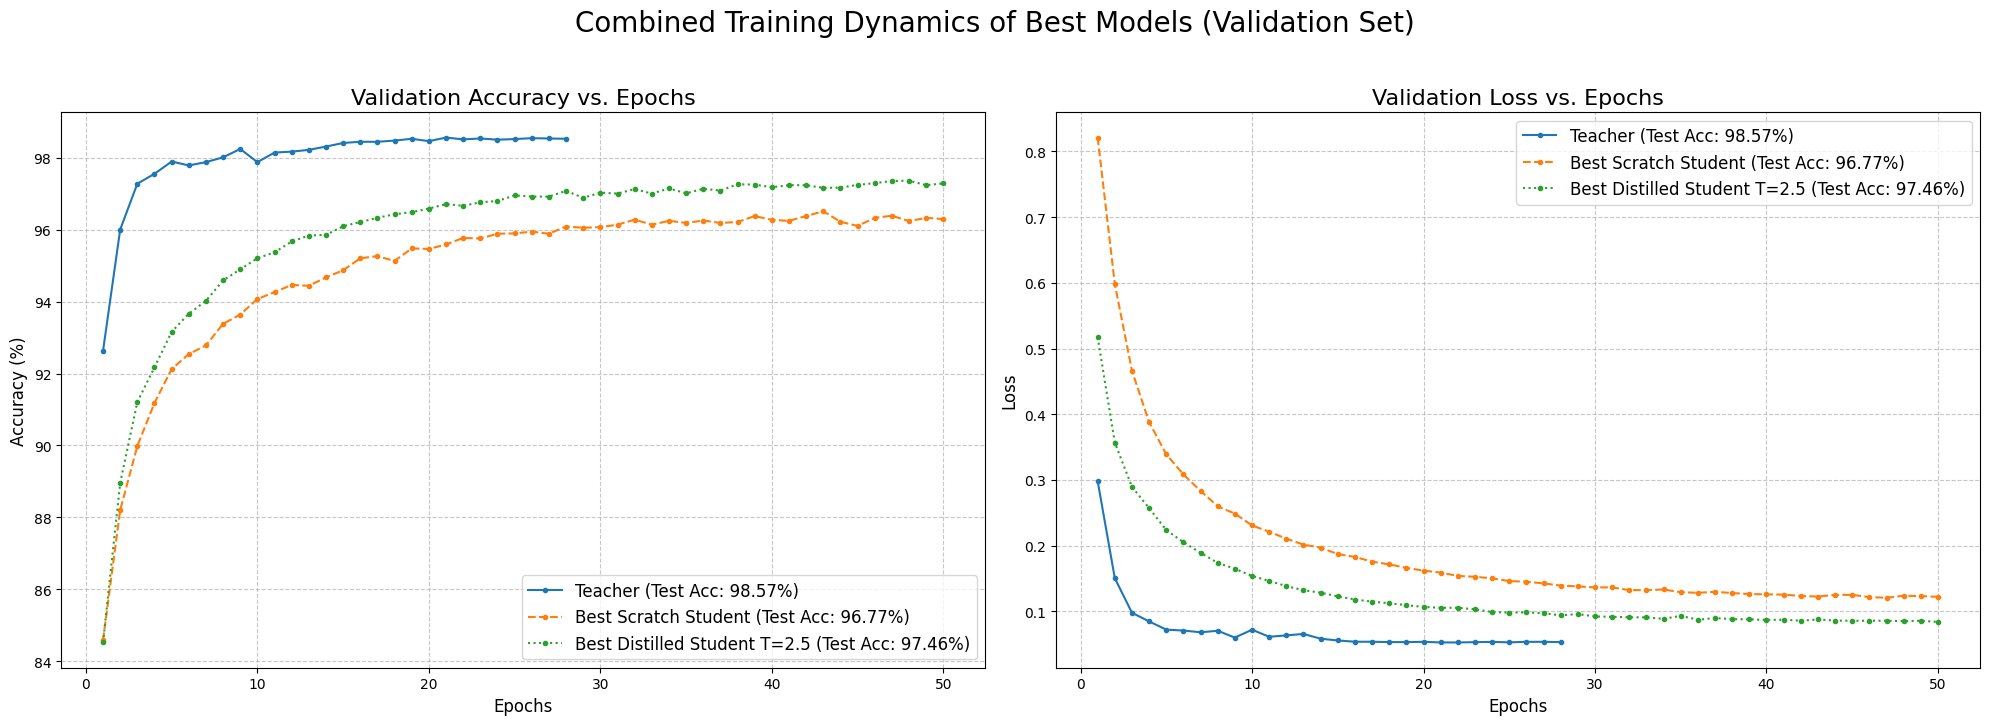

In [ ]:
# --- New Plotting Function for Combined Training History ---
def plot_combined_training_histories(histories_to_plot):
    """
    Plots the training and validation accuracy/loss for multiple models on the same axes.

    Args:
        histories_to_plot (list of dict): A list where each dict contains:
            'history': The history object from training.
            'label': The name of the model for the plot legend.
            'linestyle': The line style for the plot (e.g., '-', '--', ':').
    """
    # Create two subplots: one for accuracy, one for loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # --- Plotting Validation Accuracy ---
    for item in histories_to_plot:
        history = item['history']
        label = item['label']
        linestyle = item['linestyle']
        # Determine the number of epochs from the history length
        epochs = range(1, len(history['val_acc']) + 1)
        ax1.plot(epochs, history['val_acc'], label=label, linestyle=linestyle, marker='.')

    ax1.set_title('Validation Accuracy vs. Epochs', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- Plotting Validation Loss ---
    for item in histories_to_plot:
        history = item['history']
        label = item['label']
        linestyle = item['linestyle']
        epochs = range(1, len(history['val_loss']) + 1)
        ax2.plot(epochs, history['val_loss'], label=label, linestyle=linestyle, marker='.')

    ax2.set_title('Validation Loss vs. Epochs', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    fig.suptitle('Combined Training Dynamics of Best Models (Validation Set)', fontsize=20, y=1.03)
    plt.tight_layout()
    plt.show()

# --- Prepare data for the combined plot ---
best_T = best_distilled_run_info['T']
best_distill_acc = best_distilled_run_info['acc']

# We will plot the VALIDATION curves as they are the most informative for comparing generalization
histories_for_plot = [
    {
        'history': teacher_history,
        'label': f'Teacher (Test Acc: {teacher_test_acc:.2f}%)',
        'linestyle': '-'
    },
    {
        'history': best_scratch_run_history,
        'label': f'Best Scratch Student (Test Acc: {best_scratch_run_acc:.2f}%)',
        'linestyle': '--'
    },
    {
        'history': best_distilled_run_history,
        'label': f'Best Distilled Student T={best_T} (Test Acc: {best_distill_acc:.2f}%)',
        'linestyle': ':'
    }
]

# --- Generate the Combined Plot ---
print("\n" + "="*60)
print("       COMBINED TRAINING HISTORY OF BEST MODELS")
print("="*60)
# I'm plotting the validation curves as they better reflect how well the models generalize.
plot_combined_training_histories(histories_for_plot)

## 9. The Role of Temperature in Softening Predictions

One of the most critical concepts in knowledge distillation is the use of **temperature (T)** to "soften" the outputs of the teacher model. This section explains what that means and why it's so important.

### The Intuition: Beyond Hard Labels

When a well-trained teacher model classifies an image, its output from the final softmax layer is often very "hard." For example, for an image of a "7," the probability for the class "7" might be 99.9%, while all other class probabilities are near zero. This hard label tells the student *what* the image is, but it doesn't reveal *why*.

The teacher, however, contains more nuanced information in its pre-softmax outputs (the **logits**). These raw scores might indicate that the "7" also shares some subtle features with a "1" or a "9", but very few with a "0". This nuanced information is called **"dark knowledge."** Softening is the mechanism we use to bring this dark knowledge to the surface.

### The Mechanism: Softmax with Temperature

We modify the standard softmax function by introducing the temperature `T`. The probability $p_i$ for each class $i$ is calculated as:

$$
p_i(T) = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
$$

where $z_i$ are the logits produced by the model.

The temperature `T` controls the smoothness of the final probability distribution:
* **When T = 1:** This is the standard softmax function. It produces the "hard" probability distribution mentioned earlier.
* **When T > 1:** Dividing the logits by a temperature greater than 1 makes them smaller and closer together. When passed through the `exp` function, this results in a **softer, more uniform probability distribution**. The probabilities of incorrect classes increase, revealing the relative similarities the teacher has learned. This soft distribution provides a much richer, more informative training signal for the student.
* **When T → ∞:** As the temperature becomes very large, the probability distribution approaches a uniform distribution (e.g., 0.1 for all 10 classes), losing all specific information.

The plot below visualizes this effect. It takes the raw logits from the teacher for a single image and shows the resulting probability distribution at different temperatures. Notice how the distribution becomes "flatter" and less "peaky" as `T` increases, revealing the teacher's nuanced understanding of the input.


       FINAL TEMPERATURE SWEEP PLOT


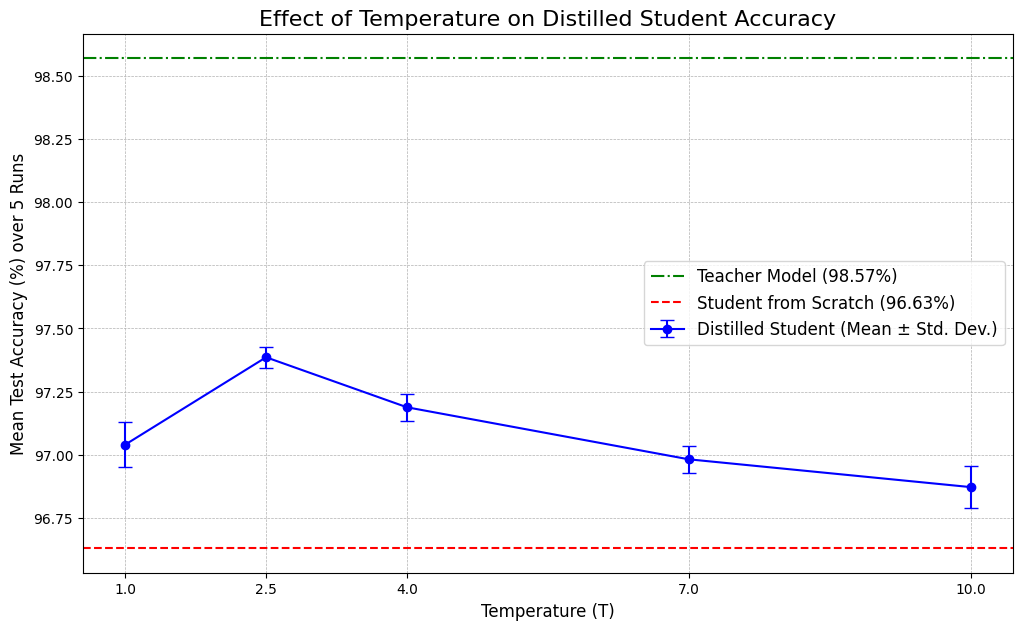

In [ ]:
# --- Plotting the Final Temperature Sweep Results ---
print("\n" + "="*60)
print("       FINAL TEMPERATURE SWEEP PLOT")
print("="*60)

plt.figure(figsize=(12, 7))

# Get the data for the plot
temps = list(mean_accuracies_by_T.keys())
means = list(mean_accuracies_by_T.values())
stds = list(std_accuracies_by_T.values())

# Plot the distilled student results with error bars
plt.errorbar(temps, means, yerr=stds, marker='o', capsize=5, linestyle='-',
             label='Distilled Student (Mean ± Std. Dev.)', color='b')

# Add horizontal lines for the teacher and scratch student baselines
plt.axhline(y=teacher_test_acc, color='g', linestyle='-.',
            label=f'Teacher Model ({teacher_test_acc:.2f}%)')
plt.axhline(y=scratch_mean, color='r', linestyle='--',
            label=f'Student from Scratch ({scratch_mean:.2f}%)')

# Formatting the plot
plt.title('Effect of Temperature on Distilled Student Accuracy', fontsize=16)
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel('Mean Test Accuracy (%) over 5 Runs', fontsize=12)
plt.xticks(TEMPERATURES) # Ensure all tested temperatures are shown as ticks
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


       VISUALIZING THE EFFECT OF TEMPERATURE


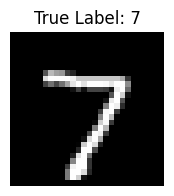

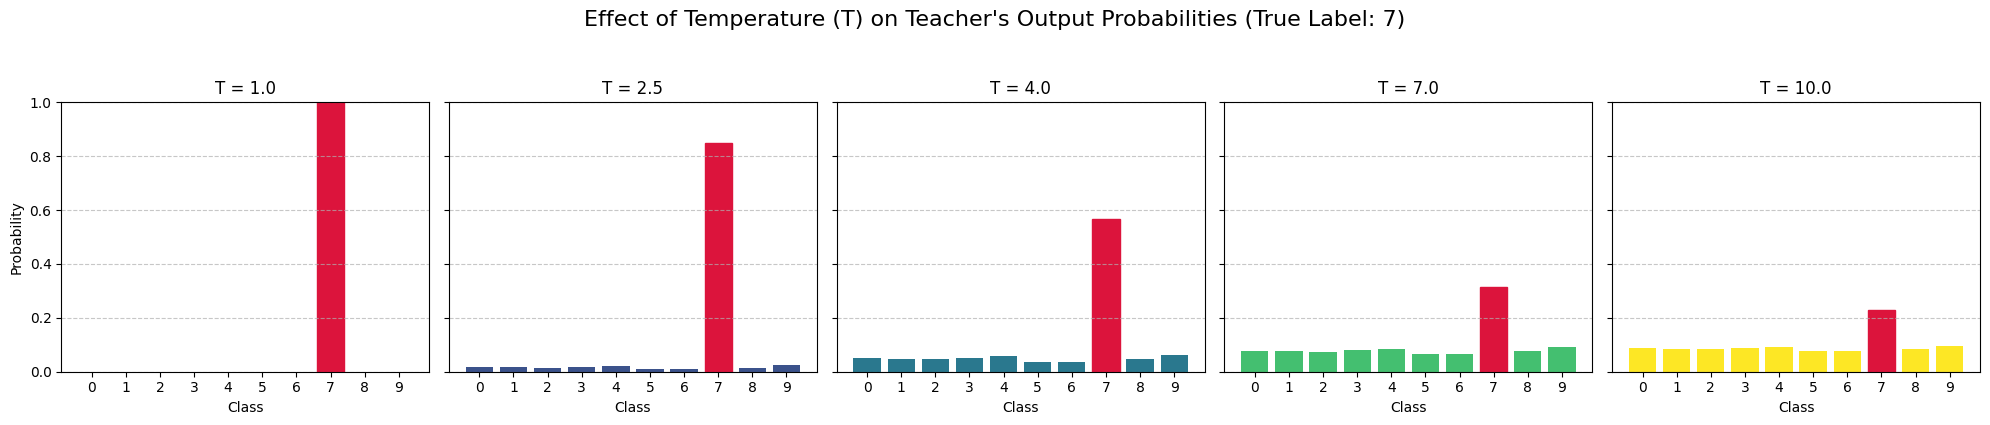

In [ ]:
# --- Visualizing the Effect of Temperature on Softmax Outputs ---
print("\n" + "="*60)
print("       VISUALIZING THE EFFECT OF TEMPERATURE")
print("="*60)

# Get a single image and its label from the test set
data, target = next(iter(test_loader))
sample_image = data[0:1].to(device)
true_label = target[0].item()

# Get the logits from the trained teacher model
best_teacher_model.eval()
with torch.no_grad():
    logits = best_teacher_model(sample_image)

# Plot the original image
plt.figure(figsize=(2, 2))
plt.imshow(sample_image.cpu().numpy().reshape(28, 28), cmap='gray')
plt.title(f"True Label: {true_label}")
plt.axis('off')
plt.show()

# Plot bar charts for different temperatures
fig, axes = plt.subplots(1, len(TEMPERATURES), figsize=(20, 4), sharey=True)
fig.suptitle(f"Effect of Temperature (T) on Teacher's Output Probabilities (True Label: {true_label})", fontsize=16, y=1.05)
class_labels = range(NUM_CLASSES)

for i, T in enumerate(TEMPERATURES):
    # Apply softmax with temperature
    soft_probs = F.softmax(logits / T, dim=1).cpu().numpy().flatten()

    ax = axes[i]
    bars = ax.bar(class_labels, soft_probs, color=plt.cm.viridis(T / max(TEMPERATURES)))
    ax.set_title(f'T = {T}')
    ax.set_xlabel('Class')
    ax.set_xticks(class_labels)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Highlight the bar for the true label
    if true_label < len(bars):
        bars[true_label].set_color('crimson')

axes[0].set_ylabel('Probability')
plt.tight_layout()
plt.show()

## 13. Conclusion and Discussion

The results of this experiment provide a clear and compelling demonstration of the effectiveness of **knowledge distillation**. By training a small, 2-layer "student" network not only on the true labels but also on the "soft targets" provided by a larger, pre-trained "teacher" network, we were able to significantly improve its performance.

### Key Findings:
1.  **Distillation Successfully Boosts Performance:** The primary conclusion is that knowledge distillation works. The student model trained from scratch achieved a respectable mean accuracy of **96.63%**. However, *every single one* of our distilled student models surpassed this baseline.

2.  **Optimal Temperature is Crucial:** The experiment highlights the importance of the `temperature (T)` hyperparameter. The best performance was achieved with **T=2.5**, which yielded a mean accuracy of **97.39%**. This represents a significant error reduction and successfully closes much of the performance gap between the baseline student and the powerful teacher model (98.57%).

3.  **The best spot for Temperature:** The results show a performance curve that increases to a certain value of the Temperature and then decreases, so we have an initial improvement of the performance and then it degrades as the Temperature keeps rising.
    * At a low temperature (T=1.0), the soft targets are too "hard" and provide little extra information beyond the true labels, leading to a smaller improvement.
    * At very high temperatures (T=7.0 and T=10.0), the soft target distribution becomes too uniform, effectively washing out the valuable "dark knowledge" and causing performance to decline.
    * **T=2.5** proved to be the "just right" value in our experiment, providing a rich, informative training signal without losing the signal in noise.

4.  **The Results are Statistically Significant:** The improvements observed are not a product of random effects. For all tested temperatures, both the **Wilcoxon signed-rank test** and the **paired t-test** returned p-values far below the 0.05 significance threshold. This provides strong statistical evidence that the distilled models are truly superior to the model trained from scratch.

5. **Further Developments:** We believe that this classification task on the MNIST dataset is too "easy" , so the performance gap between the teacher and the student from scratch is small, this lack of gap to be filled by the distilled student is not fully showing the potential of Knowledge Distillation, even though we proved here that KD is effective. What we are going to do next is to select a more difficult task, that needs more complex networks to be completed successfully, and this gives us more "space" to conduct some experiments that can show a bigger improvement of the performance achieved thanks to Knowledge Distillation procedure.

The next experiment is conducted on CNN and ResNet networks, still a classification task, on CIFAR-10 and CIFAR-100 datasets. The notebook that shows this new experiment is available on our GitHub Repository at: https://github.com/gabrielebilliciani/knowledge-distillation/blob/main/Notebook3_KD_Classification_CNNs.ipynb